In [29]:
import numpy as np
import scipy as sp
import scipy.interpolate as sinterp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import PIL


# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')



In [443]:
class SimPSFToolkit(object):
    """Simulate PSFs.
    
    In the future the zernike maps could be created with galsim.
    
    Parameters
    ----------
    zernike_maps
    pad_factor=2
    max_order=45
    max_wfe: float
        Maximum allowed WFE at ``lambda_norm``. Used for
        normalization. Units in [\mu m].
        Default is ``0.1``.
    lambda_norm: float
        Corresponds to the wavelength at which the normalization 
        of the WFE is taking place. Units in [\mu m].
        Default is ``0.550``.
    rand_seed=None
    plot_opt=True
    
    """
    
    def __init__(self, zernike_maps, max_order=45, max_wfe_rms=0.1,
                 output_dim=64, rand_seed=None, plot_opt=False, oversampling_rate=2,
                 pix_sampling=12, tel_diameter=1.2, tel_focal_length=24.5,
                 pupil_diameter=1024, verbose=0):
        # Input attributes
        self.max_order = max_order
        self.rand_seed = rand_seed
        self.plot_opt = plot_opt
        self.zernike_maps = zernike_maps
        self.max_wfe_rms = max_wfe_rms  # In [um]
        self.output_dim = output_dim  # In pixels per dimension
        self.verbose = verbose
        
        
        # Telescope characteristics
        self.oversampling_rate = oversampling_rate  # dimensionless
        self.pix_sampling = pix_sampling  # In [um]
        self.tel_diameter = tel_diameter  # In [m]
        self.tel_focal_length = tel_focal_length  # In [m]
        self.pupil_diameter = pupil_diameter  # In [pix]
        
        # Class attributes
        self.z_coeffs = None
        self.psf = None
        self.opd = None
        self.phase = None
        self.lambda_obs = None
        self.poly_psf = None
        
        # Generate pupil mask
        self.pupil_mask = ~np.isnan(self.zernike_maps[0])
        
        
    @staticmethod
    def _OLD_fft_diffraction_op(wf, pupil_mask, pad_factor=2, match_shapes=True):
        """ Perform a fft-based diffraction.

        Parameters
        ----------
        wf: np.ndarray
            A complex 2D array that corresponds to the wavefront function.
        pupil_mask: np.ndarray of bools
            A 2D boolean mask that corresponds to the pupil function.


        Returns
        -------
        psf: np.ndarray
            A real 2D array corresponding to the PSF.

        """
        start = (wf.shape[0]*pad_factor)//2 - wf.shape[0]//2
        stop = (wf.shape[0]*pad_factor)//2 + wf.shape[0]//2

        padded_wf = np.zeros((wf.shape[0]*pad_factor, wf.shape[1]*pad_factor), dtype=np.complex128)

        padded_wf[start:stop, start:stop][pupil_mask] = wf[pupil_mask]

        fft_wf = np.fft.fftshift(np.fft.fft2(padded_wf))
#         fft_wf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_wf)))
        
        psf = np.abs(fft_wf)**2
        
        if match_shapes:
            # Return the psf with its original shape without the padding factor
            x_dif = int((psf.shape[0]/pad_factor)//2)
            y_dif = int((psf.shape[1]/pad_factor)//2)        

            return psf[x_dif :psf.shape[0]-x_dif, y_dif :psf.shape[1]-y_dif]
        else:
            return psf
    
    
    @staticmethod
    def fft_diffract(wf, output_dim=64):
        # Perform the FFT-based diffraction operation
        fft_wf = np.fft.fftshift(np.fft.fft2(wf))
        psf = np.abs(fft_wf)**2
        
        # Crop the image
        start = int(psf.shape[0]//2-output_dim//2)
        stop = int(psf.shape[0]//2+output_dim//2)        

        return psf[start:stop, start:stop]
        
    
    @staticmethod
    def crop_img(to_crop_img, ref_im):
        cent_x = int(to_crop_img.shape[0]//2)
        cent_y = int(to_crop_img.shape[1]//2)
        
        delta_x = int(ref_im.shape[0]//2)
        delta_y = int(ref_im.shape[1]//2)
        
        return to_crop_img[ cent_x-delta_x : cent_x+delta_x , cent_y-delta_y : cent_y+delta_y ]
        
    
    @staticmethod
    def decimate_im(input_im, decim_f):
        """Decimate image.
        
        Decimated by a factor of decim_f.
        Based on the PIL library using the default interpolator.
        
        """

        pil_im = PIL.Image.fromarray(input_im)
        (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
        im_resized = pil_im.resize((width, height))

        return np.array(im_resized)
    
    
    @staticmethod
    def get_radial_idx(max_order=45):
        it=1
        radial_idxs = []

        while(len(radial_idxs)<=max_order):
            for _it in range(it):
                radial_idxs.append(it-1)

            it+=1

        return np.array(radial_idxs)

    
    @staticmethod
    def psf_plotter(psf, lambda_obs=0.000, cmap='gist_stern'):
        fig = plt.figure(figsize=(16,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(psf, cmap=cmap, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_xticks([]);ax1.set_yticks([])
        ax1.set_title('PSF (lambda=%.3f [um])'%(lambda_obs))

        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(np.sqrt(abs(psf)), cmap=cmap, interpolation='None')
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('sqrt PSF (lambda=%.3f [um])'%(lambda_obs))
        ax2.set_xticks([]);ax2.set_yticks([])

        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.log(abs(psf)), cmap=cmap, interpolation='None')
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('log PSF (lambda=%.3f [um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])

        plt.show()

        
    @staticmethod
    def wf_phase_plotter(pupil_mask, wf, phase, lambda_obs, cmap='viridis'):
        fig = plt.figure(figsize=(16,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(pupil_mask, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('Pupil mask')
        ax1.set_xticks([]);ax1.set_yticks([])

        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(wf, cmap=cmap, interpolation='None')
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('WF map [um]')
        ax2.set_xticks([]);ax2.set_yticks([])
        
        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.angle(phase), cmap=cmap, interpolation='None')
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('Phase map [rad] (lambda=%.3f [um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])

        plt.show()

        
    def get_psf(self):
        if self.psf is not None:
            return self.psf
        else:
            print('No PSF has been computed yet.')

            
    def plot_psf(self, cmap='gist_stern'):
        if self.psf is not None:
            self.psf_plotter(self.psf,self.lambda_obs, cmap)
        else:
            print('No PSF has been computed yet.')

            
    def plot_wf_phase(self, cmap='viridis'):
        if self.wf is not None:
            self.wf_phase_plotter(self.pupil_mask, self.wf, self.phase, self.lambda_obs, cmap)
        else:
            print('No WF has been computed yet.')

            
    def gen_random_Z_coeffs(self, max_order=45, rand_seed=None):
        """ Generate a random set of Zernike coefficients.

        The coefficients are generated following a uniform law U~[-1,1] 
        divided by their radial zernike index. 
        Ex: u_i / r(i) (u_i is a realization of U)

        Parameters
        ----------
        max_order: int
            Maximum order of Zernike polynomials.
        rand_seed: int
            Seed for the random initialization.

        Returns
        -------
        rand_coeffs: list of floats
            List containing the random coefficients.

        """
        if rand_seed is not None:
            np.random.seed(rand_seed)

        rad_idx = self.get_radial_idx(max_order)
        rad_idx[0] = 1 
        
        z_coeffs = []

        for it in range(max_order):
            z_coeffs.append((np.random.rand()-0.5)*2./rad_idx[it])

        self.z_coeffs = z_coeffs

        
    def plot_z_coeffs(self):
        """Plot random Zernike coefficients."""
        if self.z_coeffs is not None:
            fig = plt.figure(figsize=(12,6))
            ax1 = fig.add_subplot(111)
            im1 = ax1.bar(np.arange(len(self.z_coeffs)), np.array(self.z_coeffs))
            ax1.set_title('Phase map')
            ax1.set_xlabel('Zernike coefficients')
            ax1.set_ylabel('Magnitude [rad]')
            plt.show()
        else:
            print('Random coeffs not generated.')
          

    def get_z_coeffs(self):
        """Get random coefficients"""
        if self.z_coeffs is not None:
            return self.z_coeffs
        else:
            print('Random coeffs not generated.')

            
    def set_z_coeffs(self, z_coeffs):
        """Set zernike coefficients."""
        if len(z_coeffs) == self.max_order:
            self.z_coeffs = z_coeffs
        else:
            print('Zernike coefficients should be of length %d'%(self.max_order))
     
    
    def normalize_zernikes(self, z_coeffs=None, max_wfe_rms=None):
        """Normalize zernike coefficients."""
        
        if z_coeffs is None:
            if self.z_coeffs is None:
                self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
                z_coeffs = self.get_z_coeffs()
            else:
                z_coeffs = self.get_z_coeffs()
                
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
                
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]

        # Calculate normalization factor
        wfe_rms = np.sqrt(np.mean((opd[self.pupil_mask] -np.mean(opd[self.pupil_mask]))**2))
        mult_factor = max_wfe_rms / wfe_rms
        
        # Normalize Zernike coefficients and return them
        z_coeffs = [_z*mult_factor for _z in z_coeffs]
        
        return z_coeffs
        
        
    def generate_mono_PSF(self, lambda_obs=0.725, regen_sample=False, get_psf=False):
        """Generate monochromatic PSF."""
        if lambda_obs<0.55 or lambda_obs>0.9:
            print('WARNING: requested wavelength %.4f um is not in VIS passband [0.55,0.9]um'%(lambda_obs))
        self.lambda_obs = lambda_obs
        
        # Calculate the OPD from the Zernike coefficients
        self.calculate_opd(regen_sample)
          
        # Apply the diffraction operator using the opd (optical path differences)
        self.diffract_phase()
        
        if get_psf is True:
            return np.copy(self.psf)
    
    def calculate_opd(self, regen_sample=False):
        """Calculate the OPD from the Zernike coefficients."""
        if self.z_coeffs is None or regen_sample is True:
            # Generate a random sample of coefficients
            self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
            # Normalize coefficients
            z_coeffs = self.normalize_zernikes(self.get_z_coeffs(), self.max_wfe_rms)
            # Save coefficients
            self.set_z_coeffs(z_coeffs)  
            # Plot Zernike coefficients
            if self.plot_opt:
                self.plot_z_coeffs()

        else:
            # Get the stored Zernike coefficients
            z_coeffs = self.get_z_coeffs()
            
        
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
        
        # Save the wavefront
        self.opd = opd
        
    
    def diffract_phase(self, lambda_obs=None):
        """Diffract the phase map."""
        if lambda_obs is None:
            if self.lambda_obs is None:
                print('WARNING: No wavelength is defined. Using default value 0.8um.')
                lambda_obs = 0.8
            else:
                lambda_obs = self.lambda_obs
        elif lambda_obs<0.55 or lambda_obs>0.9:
            print('WARNING: wavelength %.4f is not in VIS passband [0.55,0.9]um'%(lambda_obs))
            
        # Calculate the feasible lambda closest to lambda_obs
        possible_lambda = self.feasible_wavelength(lambda_obs)
        
        # Save wavelength
        self.lambda_obs = possible_lambda
        
        # Calculate the required N for the input lambda_obs
        possible_N = self.feasible_N(self.lambda_obs)
        
        # Generate the full phase and
        # Add zeros to the phase to have the correct fourier sampling
        start = possible_N//2 - self.opd.shape[0]//2
        stop = possible_N//2 + self.opd.shape[0]//2

        self.phase = np.zeros((possible_N, possible_N), dtype=np.complex128)
        self.phase[start:stop, start:stop][self.pupil_mask] = np.exp(
            2j*np.pi*self.opd[self.pupil_mask]/self.lambda_obs)
        
        # FFT-diffract the phase (wavefront) and then crop to desired dimension
        self.psf = self.fft_diffract(wf=self.phase, output_dim=self.output_dim)
        
        # Normalize psf
        self.psf /= np.sum(self.psf)

        
    def feasible_N(self, lambda_obs):
        """Calculate the feasible N for a lambda_obs diffraction.
        
        Input wavelength must be in [um].
        """
        # Calculate the required N for the input lambda_obs
        req_N = (
            self.oversampling_rate * self.pupil_diameter * lambda_obs * self.tel_focal_length)/ (
            self.tel_diameter * self.pix_sampling)
        # Recalculate the req_N into a possible value (a pair integer)
        possible_N = int((req_N//2)*2)
        
        return possible_N
    
    def feasible_wavelength(self, lambda_obs):
        """Calculate closest fesible wavelength to target wavelength.
        
        Input wavelength must be in [um].
        """
        # Calculate a feasible N for the input lambda_obs
        possible_N = self.feasible_N(lambda_obs)
        
        # Recalculate the corresponding the wavelength
        possible_lambda = (
            possible_N * self.tel_diameter * self.pix_sampling) / (
            self.pupil_diameter * self.oversampling_rate * self.tel_focal_length)
        
        if self.verbose > 0:
            print("Requested wavelength: %.5f \nRequired N: %.2f"%(lambda_obs, req_N))
            print("Possible wavelength: %.5f \nPossible N: %.2f"%(possible_lambda, possible_N))
            
        return possible_lambda
 
    
    @staticmethod
    def gen_SED_interp(SED, n_bins=35, interp_kind='cubic'):
        """Generate SED interpolator.
        
        Returns the interpolator and the wavelengths in [nm].
        """
        wv_max = 900
        wv_min = 550
        wvlength = np.arange(wv_min, wv_max, int((wv_max-wv_min)/n_bins))
        
        SED_interp = sinterp.interp1d(
            SED[:,0], SED[:,1], kind=interp_kind, bounds_error=False, fill_value="extrapolate")
        
        return wvlength, SED_interp
 

    def generate_poly_PSF(self, SED, n_bins=35):
        """Generate polychromatic PSF with a specific SED.
        
        The wavelength space will be the Euclid VIS instrument band:
        [550,900]nm and will be sample in ``n_bins``.
        
        """
        # Generate SED interpolator and wavelengtyh array
        wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
        
        # Convert wavelength from [nm] to [um]
        wvlength_um = wvlength/1e3
        
        # Calculate feasible wavelengths (in [um])
        verbose = self.verbose
        self.verbose = 0
        feasible_wv = np.array([self.feasible_wavelength(_wv) for _wv in wvlength_um])
        self.verbose = verbose
        
        # Interpolate and normalize SED
        SED_norm = SED_interp(feasible_wv*1e3)  # Interpolation is done in [nm] 
        SED_norm /= np.sum(SED_norm)       
        
        # Plot input SEDs and interpolated SEDs
        if self.plot_opt:
            fig = plt.figure(figsize=(14,8))
            ax1 = fig.add_subplot(111)
            ax1.plot(SED[:,0],SED[:,1], label='Input SED')
            ax1.scatter(feasible_wv*1e3, SED_interp(feasible_wv*1e3), label='Interpolated', c='red')
            ax1.set_xlabel('wavelength [nm]')
            ax1.set_ylabel('SED(wavelength)')
            ax1.set_title('SED')
            ax1.legend()
            plt.show()
        
        stacked_psf = 0
        
        # Generate the required monochromatic PSFs
        for it in range(feasible_wv.shape[0]):          
            self.generate_mono_PSF(lambda_obs=feasible_wv[it])
            stacked_psf += self.get_psf()*SED_norm[it]
           
        self.poly_psf = stacked_psf
        
        return stacked_psf
    
# This pythonic version of the polychromatic calculation is not working
# The parallelisation with the class with shared variables might not be working
# It may work if we define a @staticmethod for the diffracvtion
#         psf_cube = np.array([_sed*self.generate_mono_PSF(_wv, get_psf=True) 
#                              for _wv, _sed in zip(feasible_wv, SED_norm)])
#         # Sum to obtain the polychromatic PSFs
#         self.poly_psf = np.sum(np_psf_cube, axis=0)
#         return np.copy(self.poly_psf)


In [444]:
Zcube_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)
zernikes = []
for it in range(45):
    zernikes.append(Zcube['Zpols'][0,it][5])

# Monochromatic PSF

In [445]:

# All parameters in default value
sim_PSF_toolkit = SimPSFToolkit(zernikes, max_order=45, max_wfe_rms=0.1, 
                                output_dim=64, rand_seed=None, plot_opt=True, oversampling_rate=2, 
                                pix_sampling=12, tel_diameter=1.2, tel_focal_length=24.5, 
                                pupil_diameter=1024, verbose=0)



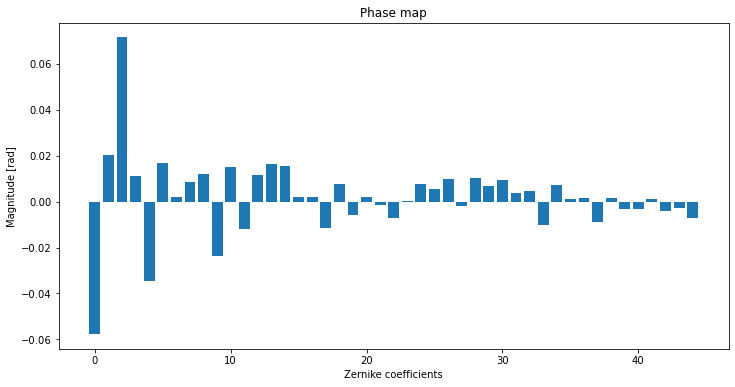

In [446]:
# Generate a random sample of coefficients
sim_PSF_toolkit.gen_random_Z_coeffs(max_order=45)
# Normalize coefficients
z_coeffs = sim_PSF_toolkit.normalize_zernikes(sim_PSF_toolkit.get_z_coeffs(), sim_PSF_toolkit.max_wfe_rms)
# Save coefficients
sim_PSF_toolkit.set_z_coeffs(z_coeffs)
# Plot Z coefficients
sim_PSF_toolkit.plot_z_coeffs()

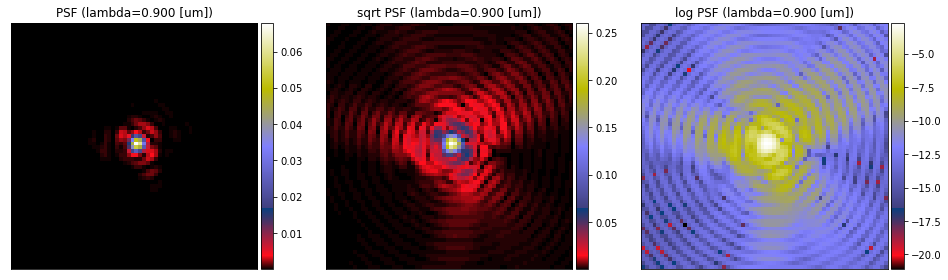

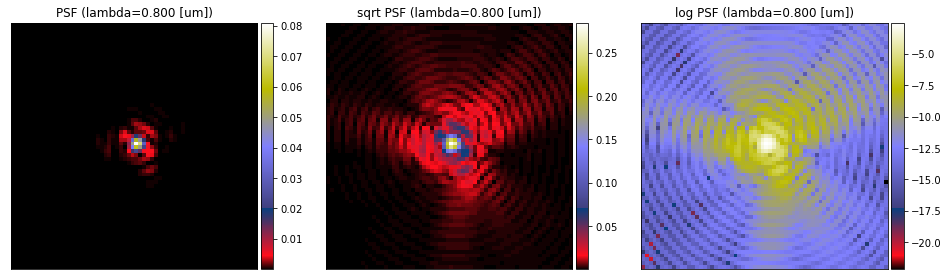

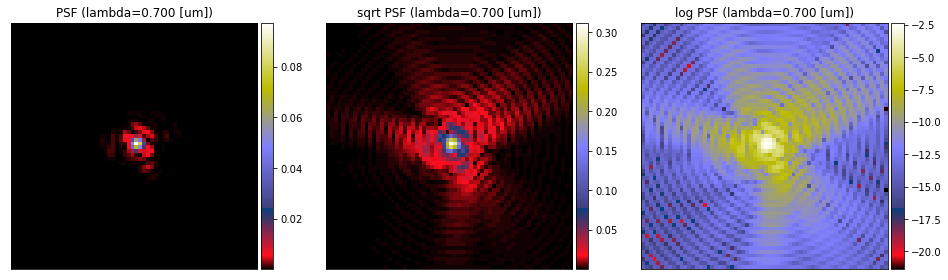

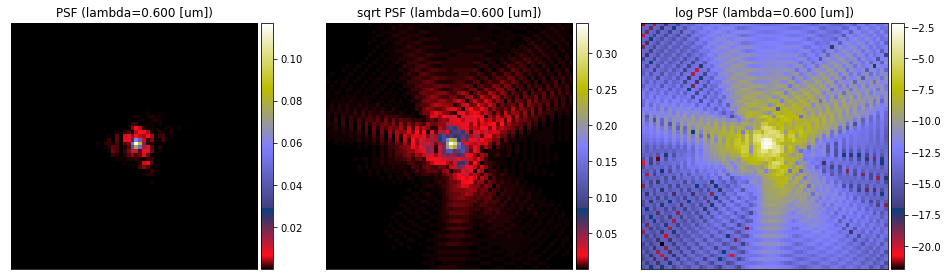

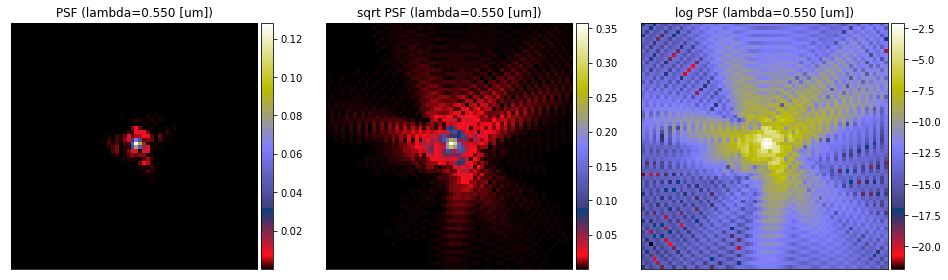

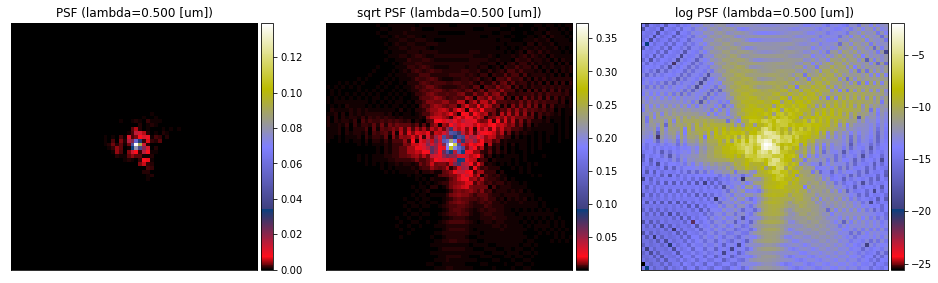

In [447]:
sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.9, regen_sample=False)
sim_PSF_toolkit.plot_psf()

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.8, regen_sample=False)
sim_PSF_toolkit.plot_psf()

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
sim_PSF_toolkit.plot_psf()

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.6, regen_sample=False)
sim_PSF_toolkit.plot_psf()

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.55, regen_sample=False)
sim_PSF_toolkit.plot_psf()

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.5, regen_sample=False)
sim_PSF_toolkit.plot_psf()

# Polychromatic PSF

In [448]:
# Load the SED
SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/templatesCOSMOS/SB1_A_0_UV.sed'
PA_SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/example_TSED.txt'

my_data = np.genfromtxt(SED_path,dtype=np.dtype('float64'))
euclid_band = np.copy(my_data)
euclid_band = euclid_band[euclid_band[:,0]>=500,:]
euclid_band = euclid_band[euclid_band[:,0]<=950,:]

PA_SED = np.genfromtxt(PA_SED_path,dtype=np.dtype('float64'))
PA_wvlength = np.arange(351)+550
PA_SED_wv = np.concatenate((PA_wvlength.reshape(-1,1), PA_SED.reshape(-1,1)), axis=1)



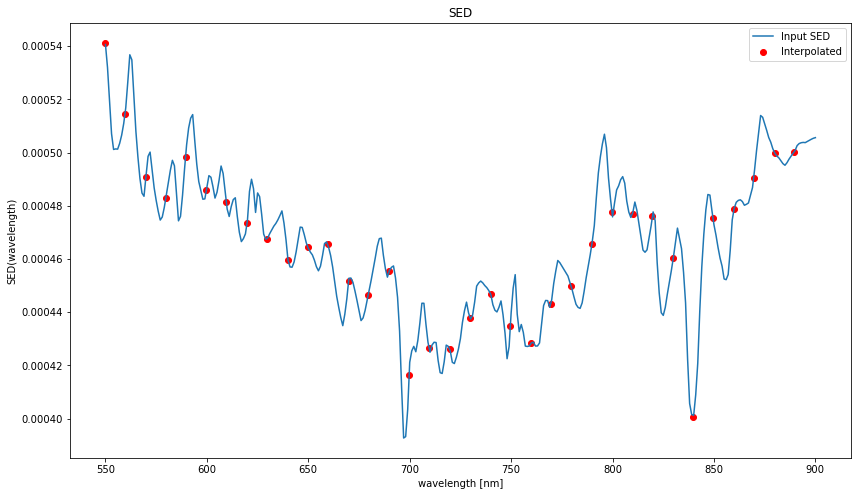

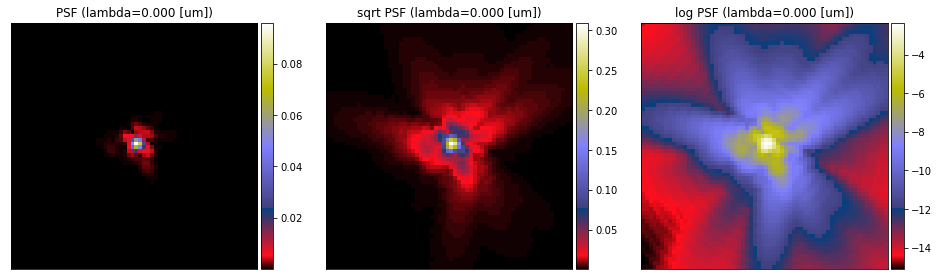

In [449]:
poly_psf_35 = sim_PSF_toolkit.generate_poly_PSF(PA_SED_wv, n_bins=35)
sim_PSF_toolkit.psf_plotter(poly_psf_35, lambda_obs=0.000, cmap='gist_stern')


In [375]:
# Generate SED interpolator and wavelengtyh array
wvlength, SED_interp = sim_PSF_toolkit.gen_SED_interp(PA_SED_wv, 35)

# Convert wavelength from [nm] to [um]
wvlength_um = wvlength/1e3

# Calculate feasible wavelengths
feasible_wv = np.array([sim_PSF_toolkit.feasible_wavelength(_wv) for _wv in wvlength_um])

# Interpolate and normalize SED
SED_norm = SED_interp(feasible_wv)
SED_norm /= np.sum(SED_norm)

# Generate the required monochromatic PSFs
psf_cube = [_sed*sim_PSF_toolkit.generate_mono_PSF(_wv, get_psf=True) for _wv, _sed in zip(feasible_wv, SED_norm)]


Requested wavelength: 0.55000 
Required N: 1916.44
Possible wavelength: 0.54987 
Possible N: 1916.00
Requested wavelength: 0.56000 
Required N: 1951.29
Possible wavelength: 0.55963 
Possible N: 1950.00
Requested wavelength: 0.57000 
Required N: 1986.13
Possible wavelength: 0.56996 
Possible N: 1986.00
Requested wavelength: 0.58000 
Required N: 2020.98
Possible wavelength: 0.57972 
Possible N: 2020.00
Requested wavelength: 0.59000 
Required N: 2055.82
Possible wavelength: 0.58948 
Possible N: 2054.00
Requested wavelength: 0.60000 
Required N: 2090.67
Possible wavelength: 0.59981 
Possible N: 2090.00
Requested wavelength: 0.61000 
Required N: 2125.51
Possible wavelength: 0.60957 
Possible N: 2124.00
Requested wavelength: 0.62000 
Required N: 2160.36
Possible wavelength: 0.61990 
Possible N: 2160.00
Requested wavelength: 0.63000 
Required N: 2195.20
Possible wavelength: 0.62966 
Possible N: 2194.00
Requested wavelength: 0.64000 
Required N: 2230.04
Possible wavelength: 0.63999 
Possible N

In [376]:
np_psf_cube = np.array(psf_cube)

In [377]:
print(np_psf_cube.shape)
poly_psf = np.sum(np_psf_cube, axis=0)
print(poly_psf.shape)

(35, 64, 64)
(64, 64)


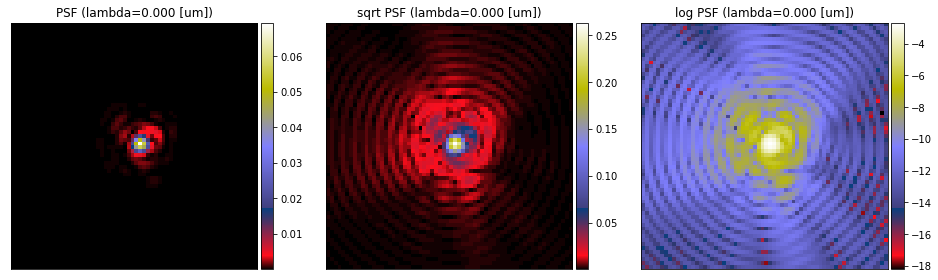

In [378]:
sim_PSF_toolkit.psf_plotter(poly_psf, lambda_obs=0.000, cmap='gist_stern')

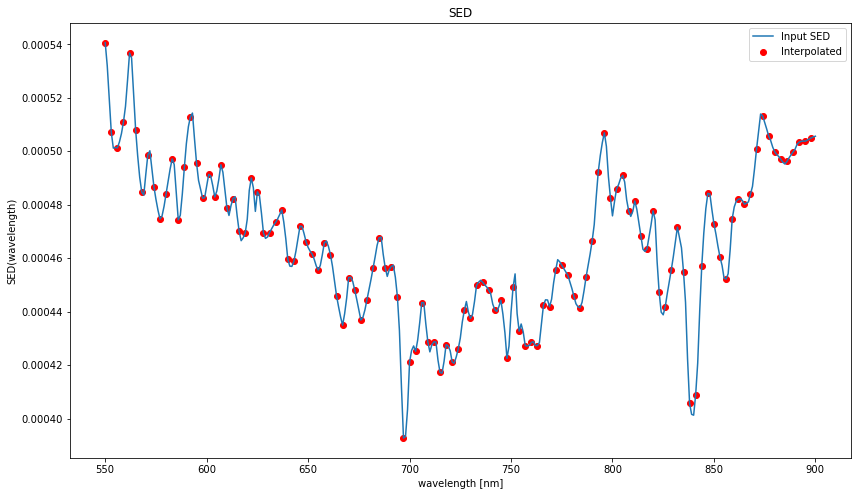

In [331]:
wvlength, SED_interp = sim_PSF_toolkit.gen_SED_interp(PA_SED_wv, n_bins=100)

# Check out the SED
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(111)
ax1.plot(PA_SED_wv[:,0],PA_SED_wv[:,1], label='Input SED')
ax1.scatter(wvlength, SED_interp(wvlength), label='Interpolated', c='red')
ax1.set_xlabel('wavelength [nm]')
ax1.set_ylabel('SED(wavelength)')
ax1.set_title('SED')
ax1.legend()
plt.show()


In [332]:
poly_psf = sim_PSF_toolkit.generate_poly_PSF(PA_SED_wv, n_bins=100)



Requested wavelength: 0.55000 
Required N: 1916.44
Possible wavelength: 0.54987 
Possible N: 1916.00
Requested wavelength: 0.55300 
Required N: 1926.90
Possible wavelength: 0.55274 
Possible N: 1926.00
Requested wavelength: 0.55600 
Required N: 1937.35
Possible wavelength: 0.55561 
Possible N: 1936.00
Requested wavelength: 0.55900 
Required N: 1947.80
Possible wavelength: 0.55848 
Possible N: 1946.00
Requested wavelength: 0.56200 
Required N: 1958.26
Possible wavelength: 0.56193 
Possible N: 1958.00
Requested wavelength: 0.56500 
Required N: 1968.71
Possible wavelength: 0.56480 
Possible N: 1968.00
Requested wavelength: 0.56800 
Required N: 1979.16
Possible wavelength: 0.56767 
Possible N: 1978.00
Requested wavelength: 0.57100 
Required N: 1989.62
Possible wavelength: 0.57054 
Possible N: 1988.00
Requested wavelength: 0.57400 
Required N: 2000.07
Possible wavelength: 0.57398 
Possible N: 2000.00
Requested wavelength: 0.57700 
Required N: 2010.52
Possible wavelength: 0.57685 
Possible N

Requested wavelength: 0.79600 
Required N: 2773.62
Possible wavelength: 0.79554 
Possible N: 2772.00
Requested wavelength: 0.79900 
Required N: 2784.07
Possible wavelength: 0.79898 
Possible N: 2784.00
Requested wavelength: 0.80200 
Required N: 2794.52
Possible wavelength: 0.80185 
Possible N: 2794.00
Requested wavelength: 0.80500 
Required N: 2804.98
Possible wavelength: 0.80472 
Possible N: 2804.00
Requested wavelength: 0.80800 
Required N: 2815.43
Possible wavelength: 0.80759 
Possible N: 2814.00
Requested wavelength: 0.81100 
Required N: 2825.88
Possible wavelength: 0.81046 
Possible N: 2824.00
Requested wavelength: 0.81400 
Required N: 2836.34
Possible wavelength: 0.81390 
Possible N: 2836.00
Requested wavelength: 0.81700 
Required N: 2846.79
Possible wavelength: 0.81677 
Possible N: 2846.00
Requested wavelength: 0.82000 
Required N: 2857.24
Possible wavelength: 0.81964 
Possible N: 2856.00
Requested wavelength: 0.82300 
Required N: 2867.70
Possible wavelength: 0.82251 
Possible N

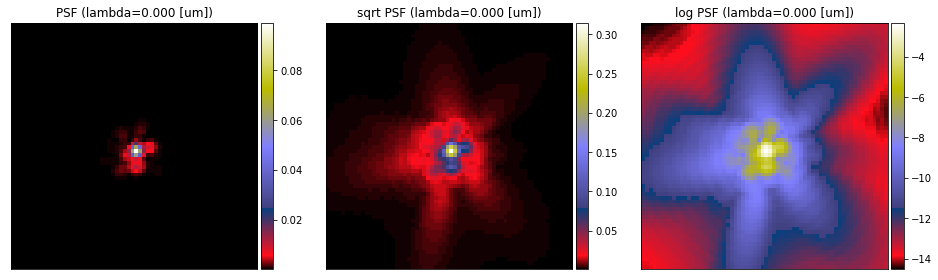

In [333]:
sim_PSF_toolkit.psf_plotter(poly_psf, lambda_obs=0.000, cmap='gist_stern')

Requested wavelength: 0.55000 
Required N: 1916.44
Possible wavelength: 0.54987 
Possible N: 1916.00
Requested wavelength: 0.56000 
Required N: 1951.29
Possible wavelength: 0.55963 
Possible N: 1950.00
Requested wavelength: 0.57000 
Required N: 1986.13
Possible wavelength: 0.56996 
Possible N: 1986.00
Requested wavelength: 0.58000 
Required N: 2020.98
Possible wavelength: 0.57972 
Possible N: 2020.00
Requested wavelength: 0.59000 
Required N: 2055.82
Possible wavelength: 0.58948 
Possible N: 2054.00
Requested wavelength: 0.60000 
Required N: 2090.67
Possible wavelength: 0.59981 
Possible N: 2090.00
Requested wavelength: 0.61000 
Required N: 2125.51
Possible wavelength: 0.60957 
Possible N: 2124.00
Requested wavelength: 0.62000 
Required N: 2160.36
Possible wavelength: 0.61990 
Possible N: 2160.00
Requested wavelength: 0.63000 
Required N: 2195.20
Possible wavelength: 0.62966 
Possible N: 2194.00
Requested wavelength: 0.64000 
Required N: 2230.04
Possible wavelength: 0.63999 
Possible N

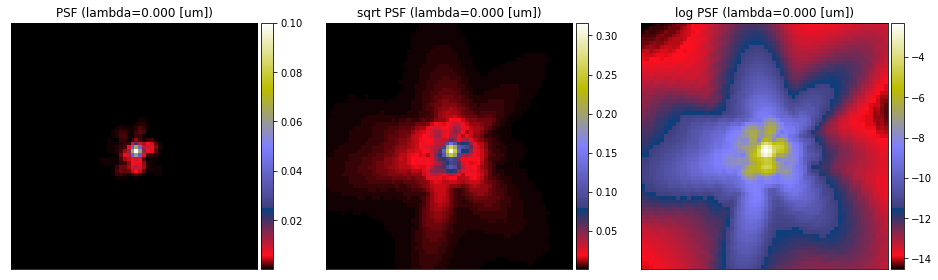

In [334]:
poly_psf_35 = sim_PSF_toolkit.generate_poly_PSF(PA_SED_wv, n_bins=35)
sim_PSF_toolkit.psf_plotter(poly_psf_35, lambda_obs=0.000, cmap='gist_stern')

Requested wavelength: 0.55000 
Required N: 1916.44
Possible wavelength: 0.54987 
Possible N: 1916.00
Requested wavelength: 0.55100 
Required N: 1919.93
Possible wavelength: 0.55045 
Possible N: 1918.00
Requested wavelength: 0.55200 
Required N: 1923.41
Possible wavelength: 0.55159 
Possible N: 1922.00
Requested wavelength: 0.55300 
Required N: 1926.90
Possible wavelength: 0.55274 
Possible N: 1926.00
Requested wavelength: 0.55400 
Required N: 1930.38
Possible wavelength: 0.55389 
Possible N: 1930.00
Requested wavelength: 0.55500 
Required N: 1933.87
Possible wavelength: 0.55446 
Possible N: 1932.00
Requested wavelength: 0.55600 
Required N: 1937.35
Possible wavelength: 0.55561 
Possible N: 1936.00
Requested wavelength: 0.55700 
Required N: 1940.84
Possible wavelength: 0.55676 
Possible N: 1940.00
Requested wavelength: 0.55800 
Required N: 1944.32
Possible wavelength: 0.55791 
Possible N: 1944.00
Requested wavelength: 0.55900 
Required N: 1947.80
Possible wavelength: 0.55848 
Possible N

Requested wavelength: 0.63200 
Required N: 2202.17
Possible wavelength: 0.63195 
Possible N: 2202.00
Requested wavelength: 0.63300 
Required N: 2205.65
Possible wavelength: 0.63253 
Possible N: 2204.00
Requested wavelength: 0.63400 
Required N: 2209.14
Possible wavelength: 0.63367 
Possible N: 2208.00
Requested wavelength: 0.63500 
Required N: 2212.62
Possible wavelength: 0.63482 
Possible N: 2212.00
Requested wavelength: 0.63600 
Required N: 2216.11
Possible wavelength: 0.63597 
Possible N: 2216.00
Requested wavelength: 0.63700 
Required N: 2219.59
Possible wavelength: 0.63654 
Possible N: 2218.00
Requested wavelength: 0.63800 
Required N: 2223.08
Possible wavelength: 0.63769 
Possible N: 2222.00
Requested wavelength: 0.63900 
Required N: 2226.56
Possible wavelength: 0.63884 
Possible N: 2226.00
Requested wavelength: 0.64000 
Required N: 2230.04
Possible wavelength: 0.63999 
Possible N: 2230.00
Requested wavelength: 0.64100 
Required N: 2233.53
Possible wavelength: 0.64056 
Possible N

Requested wavelength: 0.71400 
Required N: 2487.89
Possible wavelength: 0.71346 
Possible N: 2486.00
Requested wavelength: 0.71500 
Required N: 2491.38
Possible wavelength: 0.71460 
Possible N: 2490.00
Requested wavelength: 0.71600 
Required N: 2494.86
Possible wavelength: 0.71575 
Possible N: 2494.00
Requested wavelength: 0.71700 
Required N: 2498.35
Possible wavelength: 0.71690 
Possible N: 2498.00
Requested wavelength: 0.71800 
Required N: 2501.83
Possible wavelength: 0.71747 
Possible N: 2500.00
Requested wavelength: 0.71900 
Required N: 2505.32
Possible wavelength: 0.71862 
Possible N: 2504.00
Requested wavelength: 0.72000 
Required N: 2508.80
Possible wavelength: 0.71977 
Possible N: 2508.00
Requested wavelength: 0.72100 
Required N: 2512.28
Possible wavelength: 0.72092 
Possible N: 2512.00
Requested wavelength: 0.72200 
Required N: 2515.77
Possible wavelength: 0.72149 
Possible N: 2514.00
Requested wavelength: 0.72300 
Required N: 2519.25
Possible wavelength: 0.72264 
Possible N

Requested wavelength: 0.79600 
Required N: 2773.62
Possible wavelength: 0.79554 
Possible N: 2772.00
Requested wavelength: 0.79700 
Required N: 2777.10
Possible wavelength: 0.79668 
Possible N: 2776.00
Requested wavelength: 0.79800 
Required N: 2780.59
Possible wavelength: 0.79783 
Possible N: 2780.00
Requested wavelength: 0.79900 
Required N: 2784.07
Possible wavelength: 0.79898 
Possible N: 2784.00
Requested wavelength: 0.80000 
Required N: 2787.56
Possible wavelength: 0.79955 
Possible N: 2786.00
Requested wavelength: 0.80100 
Required N: 2791.04
Possible wavelength: 0.80070 
Possible N: 2790.00
Requested wavelength: 0.80200 
Required N: 2794.52
Possible wavelength: 0.80185 
Possible N: 2794.00
Requested wavelength: 0.80300 
Required N: 2798.01
Possible wavelength: 0.80300 
Possible N: 2798.00
Requested wavelength: 0.80400 
Required N: 2801.49
Possible wavelength: 0.80357 
Possible N: 2800.00
Requested wavelength: 0.80500 
Required N: 2804.98
Possible wavelength: 0.80472 
Possible N

Requested wavelength: 0.87800 
Required N: 3059.34
Possible wavelength: 0.87761 
Possible N: 3058.00
Requested wavelength: 0.87900 
Required N: 3062.83
Possible wavelength: 0.87876 
Possible N: 3062.00
Requested wavelength: 0.88000 
Required N: 3066.31
Possible wavelength: 0.87991 
Possible N: 3066.00
Requested wavelength: 0.88100 
Required N: 3069.80
Possible wavelength: 0.88048 
Possible N: 3068.00
Requested wavelength: 0.88200 
Required N: 3073.28
Possible wavelength: 0.88163 
Possible N: 3072.00
Requested wavelength: 0.88300 
Required N: 3076.76
Possible wavelength: 0.88278 
Possible N: 3076.00
Requested wavelength: 0.88400 
Required N: 3080.25
Possible wavelength: 0.88393 
Possible N: 3080.00
Requested wavelength: 0.88500 
Required N: 3083.73
Possible wavelength: 0.88450 
Possible N: 3082.00
Requested wavelength: 0.88600 
Required N: 3087.22
Possible wavelength: 0.88565 
Possible N: 3086.00
Requested wavelength: 0.88700 
Required N: 3090.70
Possible wavelength: 0.88680 
Possible N

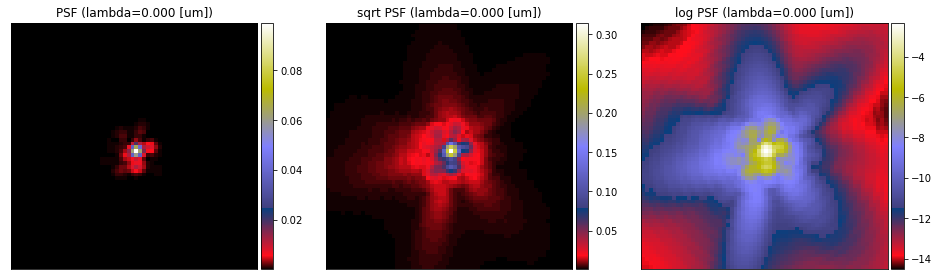

In [335]:
poly_psf_350 = sim_PSF_toolkit.generate_poly_PSF(PA_SED_wv, n_bins=350)
sim_PSF_toolkit.psf_plotter(poly_psf_350, lambda_obs=0.000, cmap='gist_stern')

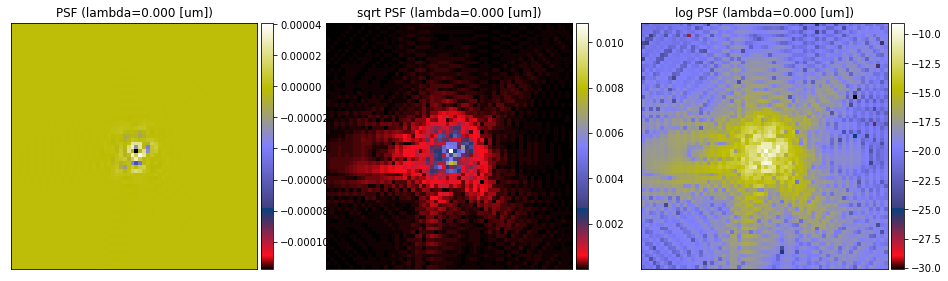

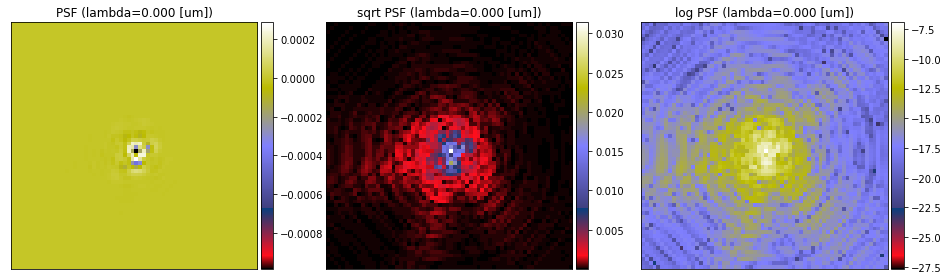

In [336]:
# Differences between the different approximations
sim_PSF_toolkit.psf_plotter(poly_psf_350 - poly_psf, lambda_obs=0.000, cmap='gist_stern')
sim_PSF_toolkit.psf_plotter(poly_psf_350 - poly_psf_35, lambda_obs=0.000, cmap='gist_stern')

In [55]:
pix_sampling=12
f_number=20.42
tel_diameter=1.2
tel_focal_length=24
m_D = 1024
N = 2048
wavelength = 0.9
NA = np.arctan(tel_diameter/(2*tel_focal_length))


In [56]:
# Required number of pixels
req_N = lambda wavelength: (m_D * wavelength * tel_focal_length) / (tel_diameter * pix_sampling)
req_N_kyle = lambda wavelength: (m_D * wavelength) / (pix_sampling * NA)

waves = np.linspace(0.55,0.9,350)


# Required pupil diameter
req_m_D = lambda wavelength: (tel_diameter * pix_sampling * N) / (wavelength * tel_focal_length)
req_m_D_kyle = lambda wavelength: (NA * pix_sampling * N) / (wavelength)


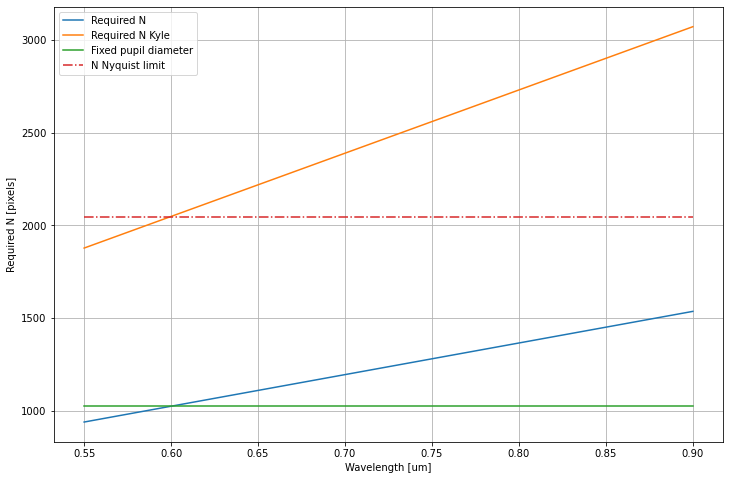

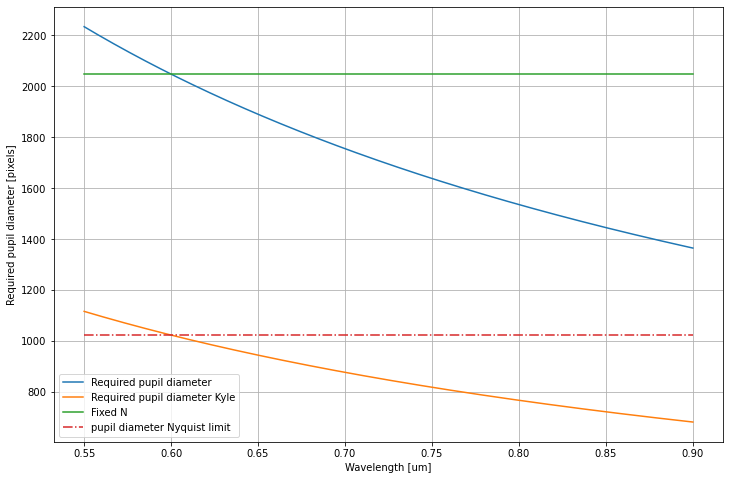

In [61]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(111)
plt.plot(waves,req_N(waves), label='Required N')
plt.plot(waves,req_N_kyle(waves), label='Required N Kyle')
plt.plot(waves,m_D*np.ones(waves.shape), label='Fixed pupil diameter')
plt.plot(waves,2*m_D*np.ones(waves.shape), '-.', label='N Nyquist limit')
ax2.set_xlabel('Wavelength [um]')
ax2.set_ylabel('Required N [pixels]')
ax2.grid('minor')
ax2.legend()
plt.show()


fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(111)
plt.plot(waves,req_m_D(waves), label='Required pupil diameter')
plt.plot(waves,req_m_D_kyle(waves), label='Required pupil diameter Kyle')
plt.plot(waves,N*np.ones(waves.shape), label='Fixed N')
plt.plot(waves,0.5*N*np.ones(waves.shape), '-.', label='pupil diameter Nyquist limit')
ax2.set_xlabel('Wavelength [um]')
ax2.set_ylabel('Required pupil diameter [pixels]')
ax2.grid('minor')
ax2.legend()
plt.show()


In [186]:
# Parameters
zernike_maps = zernikes
decim_f=16
max_order=45
max_wfe=0.1
lambda_norm=0.550
rand_seed=None
plot_opt=False

oversampling_rate=2
pix_sampling=12
tel_diameter=1.2
tel_focal_length=24.5
pupil_diameter=1024

normalize_wfe = True
max_wfe_RMS = 0.1
lambda_norm = 0.8
max_order = 45
lambda_obs = 0.8

output_shape = 128


# number pix per side, per ccd
n_pix_ccd_x = 4096 # 2x 2048
n_pix_ccd_y = 4136 # 2x 2066 + 4 pixel gap
pixelScaleAS = 0.1 # arcseconds


In [187]:
# Get some random coefficients
sim_PSF_toolkit = SimPSFToolkit(zernikes)
sim_PSF_toolkit.gen_random_Z_coeffs(45)
rand_coeffs = sim_PSF_toolkit.get_rand_coeffs()

In [274]:
# Create the phase with the Zernike basis
opd = 0
for it in range(max_order):
    opd += zernike_maps[it]*rand_coeffs[it]

# Generate pupil mask
pupil_mask = ~np.isnan(opd)

# Normalize wfe map
if normalize_wfe:
    wfe_RMS = np.sqrt(np.mean((opd[pupil_mask] -np.mean(opd[pupil_mask]))**2))
#     mult_factor = (max_wfe_RMS * lambda_norm) / wfe_RMS
    mult_factor = (max_wfe_RMS) / wfe_RMS
    opd[pupil_mask] *= mult_factor

# Save the wavefront
# self.opd = opd




In [275]:
# Define the desired lambda
lambda_obs = 0.9


In [276]:
# Calculate the required N for the input lambda_obs

# Calculate the perfect value
req_N = oversampling_rate * (pupil_diameter * lambda_obs * tel_focal_length)/ (tel_diameter * pix_sampling)
print(req_N)
# Recalculate the req_N into a possible value (a pair integer)

possible_N = int((req_N//2 + 1)*2)
print(possible_N)

possible_lambda = (possible_N * tel_diameter * pix_sampling) / (pupil_diameter * oversampling_rate * tel_focal_length)
print(possible_lambda)



3072.0000000000005
3074
0.9005859374999999


In [277]:
# Use the possible lambda

# Generate the full phase
phase = np.zeros(opd.shape, dtype=np.complex128)
phase[pupil_mask] = np.exp(2j*np.pi*opd[pupil_mask]/possible_lambda)



In [278]:
# Padd with zeros to reach the possible_N pix number
# We assume square matrices
zeros_to_add = int(possible_N - phase.shape[0])
print(zeros_to_add)

start = possible_N//2 - phase.shape[0]//2
stop = possible_N//2 + phase.shape[0]//2
print(start)
print(stop)
    
padded_phase = np.zeros((possible_N, possible_N), dtype=np.complex128)
padded_phase[start:stop, start:stop][pupil_mask] = phase[pupil_mask]

# padded_pupil_mask = ~np.isnan(padded_phase)

2050
1025
2049


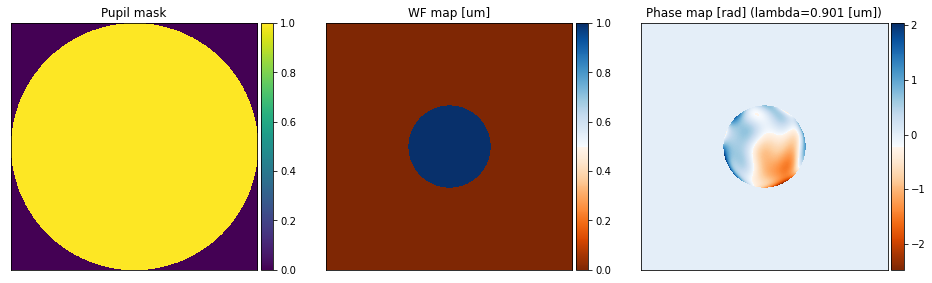

In [279]:

sim_PSF_toolkit.wf_phase_plotter(pupil_mask, abs(padded_phase), padded_phase, possible_lambda, cmap=newcmp)


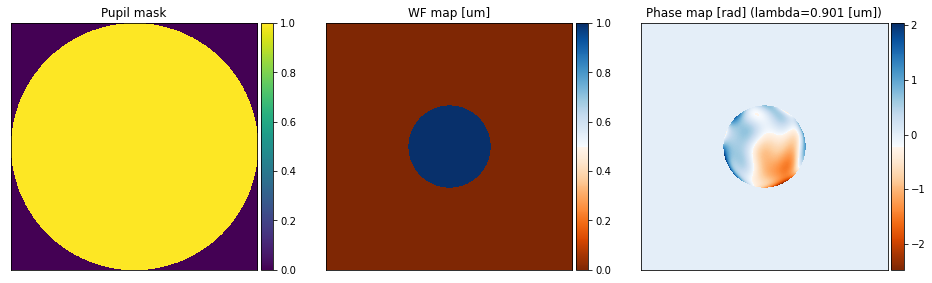

In [280]:
sim_PSF_toolkit.wf_phase_plotter(pupil_mask, abs(padded_phase), padded_phase, possible_lambda, cmap=newcmp)



In [281]:

fft_wf = np.fft.fftshift(np.fft.fft2(padded_phase))

psf = np.abs(fft_wf)**2




In [282]:
output_shape = 128
# Return the psf with its original shape without the padding factor
start = int(psf.shape[0]//2-output_shape//2)
stop = int(psf.shape[0]//2+output_shape//2)        
print(start)
print(stop)

crop_psf = psf[start:stop, start:stop]




1473
1601


In [283]:
crop_psf /= np.sum(crop_psf)


# crop_psf_1 = np.copy(crop_psf)
crop_psf_2 = np.copy(crop_psf)


0.9005859374999999


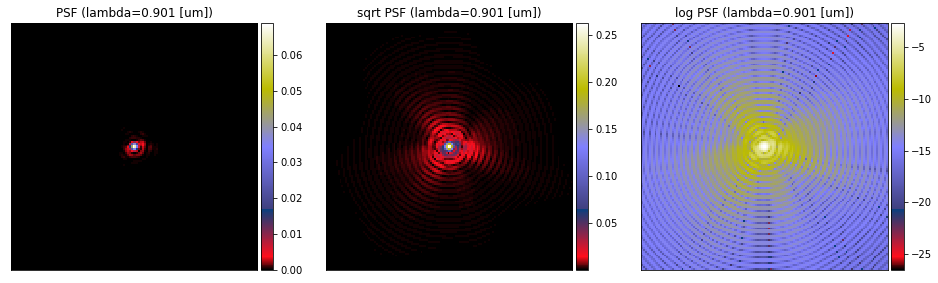

In [273]:
print(possible_lambda)
sim_PSF_toolkit.psf_plotter(crop_psf_1, lambda_obs=possible_lambda, cmap='gist_stern')

0.9005859374999999


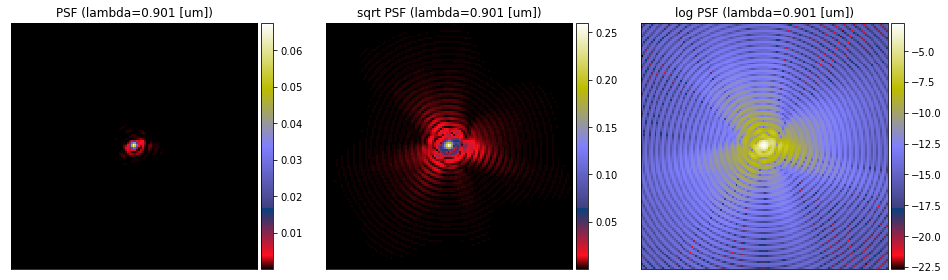

In [284]:
print(possible_lambda)
sim_PSF_toolkit.psf_plotter(crop_psf_2, lambda_obs=possible_lambda, cmap='gist_stern')

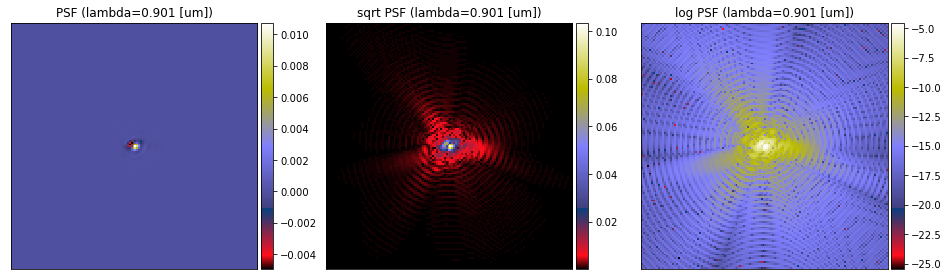

In [285]:
sim_PSF_toolkit.psf_plotter(crop_psf_1 - crop_psf_2, lambda_obs=possible_lambda, cmap='gist_stern')

0.800390625


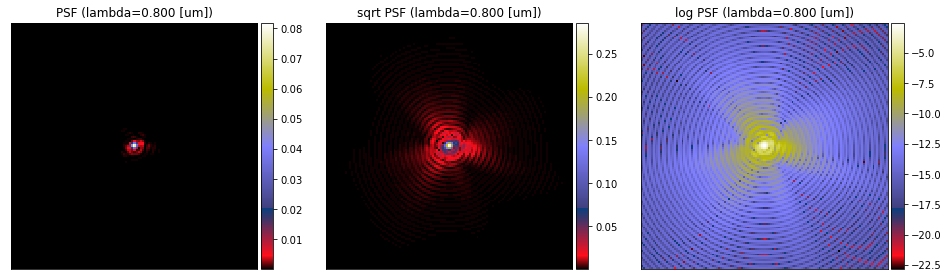

In [197]:
print(possible_lambda)
sim_PSF_toolkit.psf_plotter(crop_psf, lambda_obs=possible_lambda, cmap='gist_stern')

0.5501953125


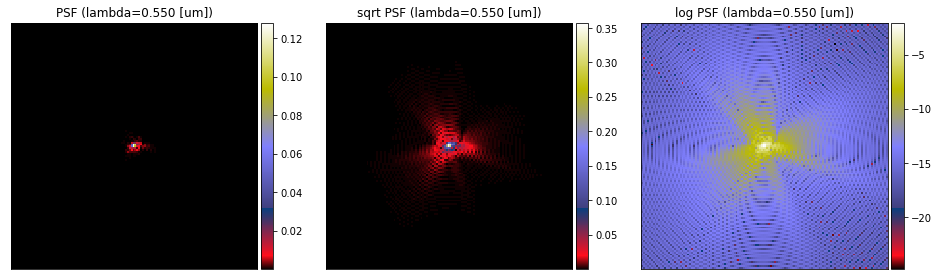

In [207]:
print(possible_lambda)
sim_PSF_toolkit.psf_plotter(crop_psf, lambda_obs=possible_lambda, cmap='gist_stern')

0.650390625


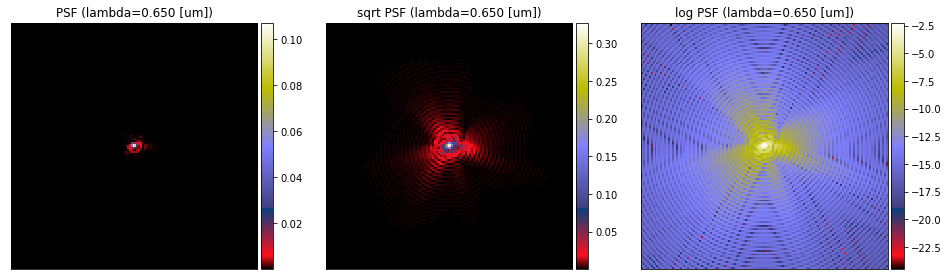

In [217]:
print(possible_lambda)
sim_PSF_toolkit.psf_plotter(crop_psf, lambda_obs=possible_lambda, cmap='gist_stern')

0.7505859375


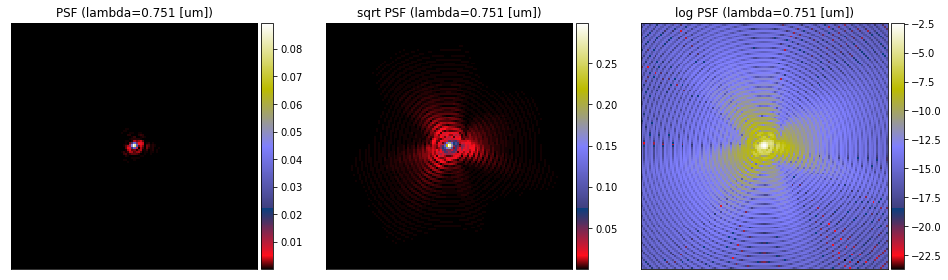

In [227]:
print(possible_lambda)
sim_PSF_toolkit.psf_plotter(crop_psf, lambda_obs=possible_lambda, cmap='gist_stern')

0.9005859374999999


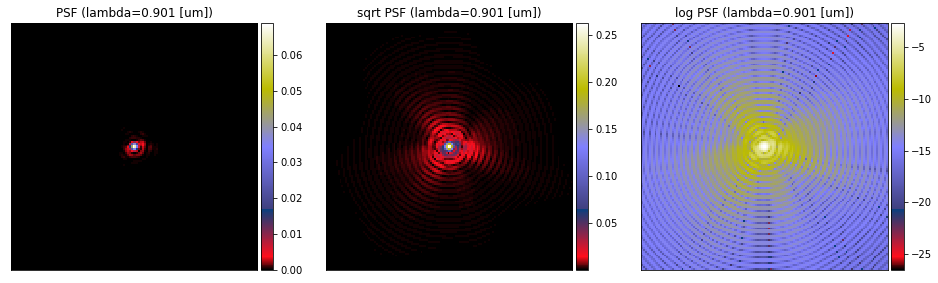

In [237]:
print(possible_lambda)
sim_PSF_toolkit.psf_plotter(crop_psf, lambda_obs=possible_lambda, cmap='gist_stern')